In [485]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly_express as px
import plotly.io as pio
from sklearn import preprocessing
import pandas_profiling
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import warnings
import math
import plotly.express as px
import statsmodels
import scipy
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests


import math


warnings.filterwarnings("ignore")

# scipy
print('scipy: %s' % scipy.__version__)
# numpy
print('numpy: %s' % np.__version__)
# matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
print('pandas: %s' % pd.__version__)
# scikit-learn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
print('statsmodels: %s' % statsmodels.__version__)
#print('unicodedata: %s' % unicodedata.__version__)

scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.22.2.post1
statsmodels: 0.11.1


In [486]:
#verificar feriados 
def isHoliday(dia,mes):
    if dia == 1:
        if mes == 1 or mes ==5:
            return(True)
    if (dia ==2 or dia==15) and mes==11:
        return(True)
    if (dia ==7 or dia==20) and mes == 9:
        return(True)
    if mes == 4 and dia==21:
        return(True)    
    if mes==10 and (dia==12):
        return(True)
    if mes==12 and (dia ==25 or dia ==24):
        return(True)
    if mes==12 and dia==31:
        return(True)
    return(False)   

def AdjustFeriado(x):
    #print(x)
    if x['Feriado'] == 0 or x['Feriado'] == 1:
        return(x['Feriado'])
       # print('else')
       # print(x['Feriado'] >=0)
    else:
        dia = x['judgmentDate'].day
        mes = x['judgmentDate'].month 
        feriado = 0 if isHoliday(dia,mes) == True else 1
        return(feriado)
    
def AdjustWeekDay(x):    
    if x['weekDay'] > 0:
        return(x['weekDay'])
    else:
        return(x['judgmentDate'].weekday())        
    
def AdjustWeekType(x):    
    if x['weekType'] > 0:
        return(x['weekType'])
    else:
        weekType = 1 if x['judgmentDate'].weekday() <5 else 0
        return(weekType)     

In [487]:
from statsmodels.tsa.stattools import adfuller

def adf_teste(series,title='',prints=False):    
    summay = ''
    if prints:
        print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC',) 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():        
        out[f'critical value ({key})']=val
        
    if prints:
        display(pd.DataFrame(out))
    
    
    
    if result[1] <= 0.05:
        summary = "Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary"
        if prints:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")
            print("Data has no unit root and is stationary")        
    else:
        summary = "Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary"
        if prints:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
            
    
    return(result[1],title,result[0],result[2],result[3],result[4],result[5],summary) 

def TooDifferent(item1,item2):
    print(df[item1].sum(),'',df[item2].sum())
    return (df[item1].sum()/10 >  df[item2].sum() or  df[item2].sum()/10 >  df[item1].sum())

In [488]:
#carrega
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",")#,parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

dfUniqueTypes = df_count_day_type['type'].unique()

#cria indice
df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])

#deleta colunas que sobraram da importacao e da criacao do indice
del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

#calcula o total do dia
df_count_day_type['total'] = df_count_day_type.groupby(['judgmentDate'])['count'].agg('sum')
#salva as informacoes que nao serao pivotadas
ref = df_count_day_type[['weekDay','weekType','Feriado','total']]
#realiza o pivot
df_count_day_typeGRP = df_count_day_type.pivot(columns='type', values='count').fillna(0)

#transforma tudo pra int (count)
for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)
        
#faz o merge com as que foram salvas antes do pivot        
df_count_day_typeGRP = pd.merge(df_count_day_typeGRP,ref,on='judgmentDate',how='left')
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate').drop_duplicates()

#remove duplicadas e nulas pra fazer a frequencia diaria
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP = df_count_day_typeGRP.drop_duplicates()
df_count_day_typeGRP = df_count_day_typeGRP.dropna()


df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP['Feriado'].apply( lambda x: 0 if x==True else 1)
df_count_day_typeGRP['weekType'] = pd.get_dummies(df_count_day_typeGRP['weekType'])
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D') #precisa pois abaixo seto os que faltam

#reseta o indice agora com todos os dias inclusive vazios e seta as informaçoes das datas novas (sem dados)
df_count_day_typeGRP = df_count_day_typeGRP.reset_index()    
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP.apply(AdjustFeriado,axis=1)
df_count_day_typeGRP['weekDay'] = df_count_day_typeGRP.apply(AdjustWeekDay,axis=1)
df_count_day_typeGRP['weekType'] = df_count_day_typeGRP.apply(AdjustWeekType,axis=1)

#volta ao estado normal (com indice e frequencia)
df_count_day_typeGRP.index = df_count_day_typeGRP['judgmentDate']
del df_count_day_typeGRP['judgmentDate']
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D')

#seta para zerado as datas que nao existiam antes 
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)

for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)


In [489]:
dfOutli = []
df = df_count_day_typeGRP.resample('QS').sum().copy()
df = df['2012-01-01':]
valor = df['total'].sum()# - 1619483 - 1366115 - 813246
for i in df.columns:    
    dfOutli.append({'nome':i,'Qtd':df[i].sum(),'Percent':round((df[i].sum()*100)/valor,2),'QtdDiasZero':df[df[i]==0][[i]].count().item(),'QtdNaoZero':df[df[i]!=0][[i]].count().item()})

    
#PEGAR SO AQUELES QUE TEM QUANTIDADE SENAO NAO ADIANTA FAZER VAR
    
dfValidTypes = pd.DataFrame(dfOutli).sort_values(by='Percent',ascending=False)
# ver apenas aqueles que tem dados em pelo menos 50% ou mais dos quartis
#display(dfValidTypes[dfValidTypes['QtdNaoZero']>12])

dfListOfTypes = np.array(dfValidTypes[dfValidTypes['QtdNaoZero']>12]['nome'])
dfListOfTypes = np.append(dfListOfTypes,'weekDay')
dfListOfTypes = np.append(dfListOfTypes,'weekType')
dfListOfTypes = np.append(dfListOfTypes,'Feriado')
dfListOfTypes

array(['total', 'Apelação Cível', 'Agravo de Instrumento',
       'Embargos de Declaração', 'Recurso Cível', 'Agravo',
       'Apelação Crime', 'Habeas Corpus', 'Apelação e Reexame Necessário',
       'Reexame Necessário', 'Recurso Crime', 'Conflito de Competência',
       'Recurso em Sentido Estrito', 'Agravo Regimental',
       'Mandado de Segurança', 'Embargos Infringentes e de Nulidade',
       'weekDay', 'Embargos Infringentes', 'Ação Rescisória',
       'Revisão Criminal', 'Correição Parcial', 'Conflito de Jurisdição',
       'Feriado', 'Mandado de Injunção', 'Agravo Interno', 'weekType',
       'Ação Direta de Inconstitucionalidade', 'Petição',
       'Exceção de Suspeição', 'Mandado de Segurança Crime',
       'Incidente de Uniformizacao Jurisprudencia', 'Carta Testemunhável',
       'Representação Criminal', 'Recurso de Ofício',
       'Cautelar Inominada', 'Ação Penal',
       'Uniformização de Jurisprudência', 'Termo Circunstanciado',
       'Restauração de Autos', 'Medida C

In [490]:
df_count_day_typeGRP.head(3)
df = df_count_day_typeGRP

#USAR SOMENTE SERIES QUE NAO CONTENHAM POUCOS REGISTROS 
df = df[dfListOfTypes]
dfMonth = df.resample('MS').sum()
dfQuarter = df.resample('QS').sum()
dfYear = df.resample('Y').sum()
dfAllPeriod = df.resample('30A').sum()
figsize=(12,8)
field = 'total'

In [491]:
dfMonth = dfMonth[[field]]

In [492]:
len(dfMonth)
dfMonthTrain = dfMonth.iloc[:204]
dfMonthTest =  dfMonth.iloc[204:]

In [493]:
dfMonthTrain

,total
judgmentDate,
2000-01-01,10
2000-02-01,222
2000-03-01,573
2000-04-01,647
2000-05-01,1096
...,...
2016-08-01,42889
2016-09-01,38185
2016-10-01,38016


In [362]:
# Necessário normalizar os valores 
from sklearn.preprocessing import MinMaxScaler

In [363]:
scaler = MinMaxScaler()
scaler.fit(dfMonthTrain)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [364]:
scaleed_train = scaler.transform(dfMonthTrain)
scaleed_test = scaler.transform(dfMonthTest)

In [365]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [366]:
n_input =2 
n_features = 1 

generator = TimeseriesGenerator(scaleed_train, scaleed_train,length=n_input,batch_size=1)

In [367]:
generator[0],len(scaleed_train),len(generator)

((array([[[0.        ],
          [0.00462397]]]),
  array([[0.01227971]])),
 204,
 202)

In [368]:
X,y = generator[0]

In [369]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [370]:
n_input =12
n_features = 1 #quantidade de colunas, no caso só Y 

train_generator = TimeseriesGenerator(scaleed_train, scaleed_train,length=n_input,batch_size=1)

train_generator

In [371]:
model = Sequential()
model.add(LSTM(25,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [372]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 25)                2700      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 26        
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________


In [314]:
model.fit_generator(train_generator,epochs=15)

Epoch 1/15
192/192 [==============================] - 1s 7ms/step - loss: 0.0247
Epoch 2/15
192/192 [==============================] - 1s 5ms/step - loss: 0.0088
Epoch 3/15
192/192 [==============================] - 1s 5ms/step - loss: 0.0090
Epoch 4/15
192/192 [==============================] - 1s 5ms/step - loss: 0.0091
Epoch 5/15
192/192 [==============================] - 1s 5ms/step - loss: 0.0090
Epoch 6/15
192/192 [==============================] - 1s 5ms/step - loss: 0.0084
Epoch 7/15
192/192 [==============================] - 1s 5ms/step - loss: 0.0087
Epoch 8/15
192/192 [==============================] - 1s 5ms/step - loss: 0.0089
Epoch 9/15
192/192 [==============================] - 1s 5ms/step - loss: 0.0090
Epoch 10/15
192/192 [==============================] - 1s 5ms/step - loss: 0.0087
Epoch 11/15
192/192 [==============================] - 1s 5ms/step - loss: 0.0089
Epoch 12/15
192/192 [==============================] - 1s 5ms/step - loss: 0.0084
Epoch 13/15
192/192 [====

In [373]:
model.history.history.keys()

AttributeError: 'Sequential' object has no attribute 'history'

In [374]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

AttributeError: 'Sequential' object has no attribute 'history'

In [375]:
first_eval_batch = scaleed_train[-n_input:] #pega os ultimos 12 do treino para prever o teste 

first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [376]:
scaleed_test

array([[0.18790351],
       [0.59265399],
       [0.96715233],
       [0.70040133],
       [0.79257547],
       [0.72978102],
       [0.73074071],
       [0.89733467],
       [0.7151457 ],
       [0.81549904],
       [0.80598936],
       [0.63091084]])

In [377]:
model.predict(first_eval_batch)

array([[0.1412589]], dtype=float32)

In [378]:
#hold predictions
test_predictions = [] 

# las n input from the train set 
first_eval_batch = scaleed_train[-n_input:]
#reshape para fcar no formato do timeseries Generator
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#quantidade de meses a frente a previsao ... normalmente pega o mesmo que seria o tamanho do test
# vai substituindo cada valor com o historico do anterior, ja levando em conta o quanto ele previu pro anterior
for i in range(len(dfMonthTest)):
    #um passo a frente do historico ... 12 pontos
    current_pred = model.predict(current_batch)[0]    
    #grava a predicao
    test_predictions.append(current_pred)
    #atualiza o current batch com a predição
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    #print(current_batch.flatten())

In [379]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[6486.43783617],
       [5535.56660295],
       [4702.9265945 ],
       [3906.69677228],
       [3229.47291052],
       [2631.78601757],
       [2083.26051065],
       [1637.38714096],
       [1242.2182238 ],
       [ 924.04156929],
       [ 652.86904794],
       [ 427.8461618 ]])

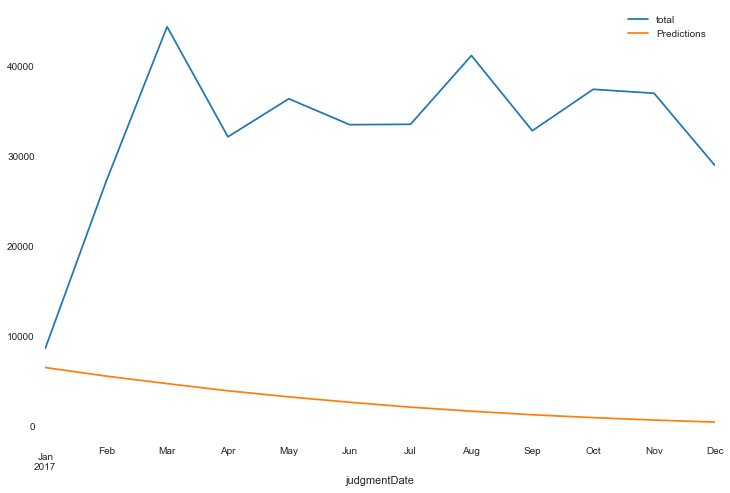

In [380]:
dfMonthTest['Predictions'] = true_predictions
dfMonthTest.plot(figsize=figsize)

In [381]:
model.save('modelo.h5')

In [382]:
from keras.models import load_model
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

new_model = load_model('modelo.h5')
new_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 25)                2700      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 26        
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________


In [520]:
import glob
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch

In [521]:
df = dfMonth['total']
df = df.sort_values('judgmentDate')
df.set_index('judgmentDate', inplace=True) # set index to timestamp
df.head()

ValueError: No axis named judgmentDate for object type <class 'pandas.core.series.Series'>

In [ ]:
df_vwap = df.groupby(pd.Grouper(freq="MS")).apply(
    lambda row: pd.np.sum(row.price * row.foreignNotional) / pd.np.sum(row.foreignNotional))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)